# CS4225/5425 Assignment 1 Task 1

Note: first save your own copy of this Colab notebook (File > Save a copy in Drive), which should automatically open the copy, which you can then edit.

- **Your Name:** Wong Kit Long
- **Your Student Number** (starting with A): A0275793L

We will be using Hadoop Streaming, a variant of Hadoop. Before starting this assignment, go over Assignment 0 to familiarize with the basics of using Hadoop Streaming.

# Dataset

The data comes from the NUS SMS Corpus, consisting of messages collected around 2011, mostly originating from students attending the University (https://arxiv.org/abs/1112.2468). These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available.

Each dataset has multiple lines, each line representing a single message, and formatted as a JSON object (hence, they are "JSON Lines" files, with extension `.jsonl`). The large file has 55835 messages, `sms_small.jsonl` which has 5 messages and `small_sms_dup.jsonl` which has 9 messages. The small file is optional to use, but may be useful for debugging (as it runs faster and you can more easily check the exact answers). If you wish to test your code for task 1, use the `small_sms_dup.jsonl` as the `sms_small.jsonl` does not have any duplicate messages.

To help you understand the data format, the following shows the 1st message in the small dataset. The most important variables are the text message (`text`), and the `source` object, which contains user information about the message sender (`userProfile`). Note that the value associated with the `text` key is actually a JSON object, containing key "`$`", and the actual text as the value. The same is true for most of the other information in this data structure.

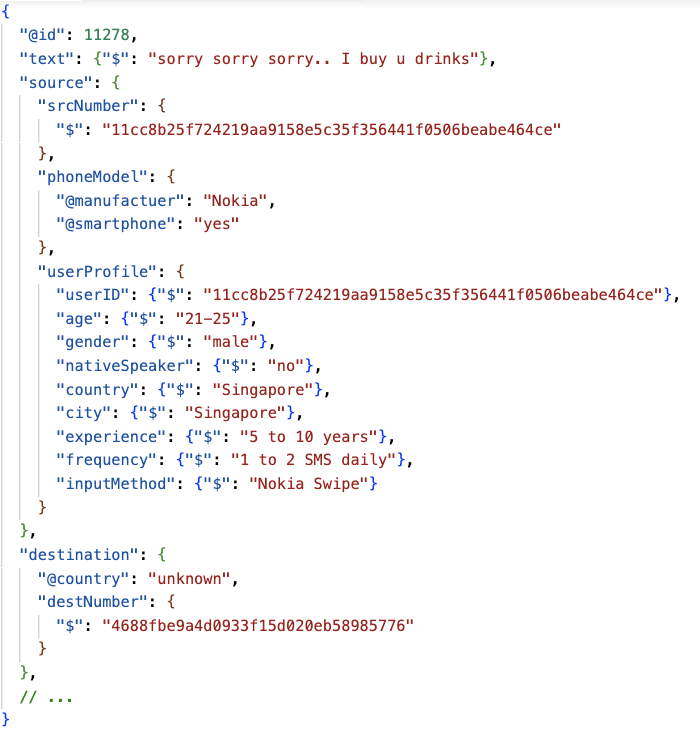

**Example 1**: A single message, stored as a JSON object. In the dataset, this message is represented as a single line (but is expanded here for clarity). `text` shows the actual message text, while the `country` the user is from is also recorded in the data.

# Task (10 marks)

Handling of duplicate entries (eg. identification, deduplication etc.) within a dataset is a well known use case of MapReduce. In this task, we will implement a solution that identifies "duplicate" entries in a dataset.

Your task is as follows: return all message IDs (`@id`) of messages that is a duplicate of some other message in the dataset. A message is considered to be a duplicate of another message if the sender (`srcNumber`), recipient (`destNumber`) and **hash value** of message text (`text`) are the same. You should also disregard messages with the value **"unknown"** for the `srcNumber` or `destNumber` fields. <br>
To get the hash value of the message text, use the `hashlib` library's `sha256()` function. For example:

```python
from hashlib import sha256

target_sentence = "Welcome to CS4225 Assignment 1 Task 1"
hashed_sentence = sha256(target_sentence.encode()).hexdigest()
print(hashed_sentence) #4631771eeb2c5dd1c338eca2c4f4794d7199ec0b87aa2d47d355168763fde62b
```

Example of duplicate messages (irrelevant fields not shown):
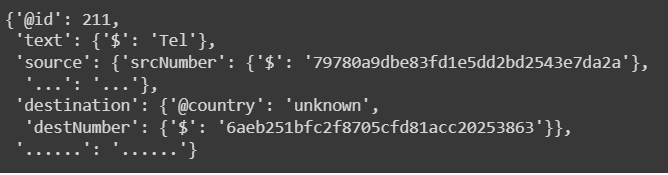
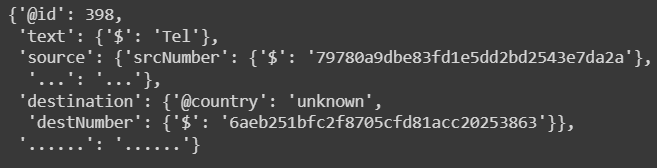

## Submission

The file `task_1_sample_answer.txt` shows an example, which is the output from running your program on the `small_sms_dup.jsonl` dataset. Do note that the order of the message_ids do not have to be in any particular order, as long as you return the whole set of message_ids.

**Submission.** Submit to Canvas a zip file containing your notebook renamed as `task1.ipynb` (you can download via File > Download) and your final output file as `task1.txt` (called `part-00000` under 'Files', which should be automatically produced by Hadoop and stored at `/content/output/part-00000` while running your Hadoop job). Save the zip file as `<your student number>`.zip, with your student number (starting with A) <u>along with the other files as required in Task 2 of this assignment.</u>

**Remarks.** Naturally, there are other interesting questions that could also be explored using this dataset: how about other dimensions like age, gender, or mobile phone brand (which are also in the dataset)? However, for our actual assignment, to avoid issues due to multiple MapReduce jobs (like their files over-writing one another), we focus on just one precise task, particularly since this Colab version of the assignment is still new and being tested for now.

# Installing Hadoop

First, we need to download and install Hadoop to the `usr/local` directory, and then set the `JAVA_HOME` environment variable so Hadoop knows where to find Java on our system. The installation process should take 45 seconds or so. Note that if you refresh the colab notebook, you need to run this cell again before you can use Hadoop.

In [8]:
!wget https://dlcdn.apache.org/hadoop/common/hadoop-3.3.6/hadoop-3.3.6.tar.gz
!tar -xzf hadoop-3.3.6.tar.gz
# install hadoop to /usr/local
!cp -r hadoop-3.3.6/ /usr/local/
import os
# hadoop needs to know where java is located
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# the following line reduces the amount of Hadoop's printed output, to make it easier to see your own debug output
os.environ["HADOOP_ROOT_LOGGER"] = "WARN,console"

--2024-03-17 13:29:43--  https://dlcdn.apache.org/hadoop/common/hadoop-3.3.6/hadoop-3.3.6.tar.gz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 730107476 (696M) [application/x-gzip]
Saving to: ‘hadoop-3.3.6.tar.gz.1’

hadoop-3.3.6.tar.gz 100%[===================>] 696.28M   148MB/s    in 5.8s    

2024-03-17 13:29:49 (120 MB/s) - ‘hadoop-3.3.6.tar.gz.1’ saved [730107476/730107476]



# Downloading the Data

The data file to be downloaded in the abovementioned dataset from NUS SMS Corpus (`sms.jsonl`), a smaller version of the dataset (`small_sms_dup.jsonl`) and it's expected output (`task_1_sample_answer.txt`). Downloading it using `wget` stores it into the `/content/` directory.

In [9]:
!wget https://bingshenghe.github.io/teaching/cs4225/assign1/sms.jsonl
!wget https://bingshenghe.github.io/teaching/cs4225/assign1/small_sms_dup.jsonl
!wget https://bingshenghe.github.io/teaching/cs4225/assign1/task_1_sample_answer.txt

--2024-03-17 13:30:27--  https://bingshenghe.github.io/teaching/cs4225/assign1/sms.jsonl
Resolving bingshenghe.github.io (bingshenghe.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to bingshenghe.github.io (bingshenghe.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45928744 (44M) [application/octet-stream]
Saving to: ‘sms.jsonl.1’

sms.jsonl.1         100%[===================>]  43.80M   157MB/s    in 0.3s    

2024-03-17 13:30:28 (157 MB/s) - ‘sms.jsonl.1’ saved [45928744/45928744]

--2024-03-17 13:30:28--  https://bingshenghe.github.io/teaching/cs4225/assign1/small_sms_dup.jsonl
Resolving bingshenghe.github.io (bingshenghe.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to bingshenghe.github.io (bingshenghe.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6997 (6.8K) [application/octet-stream]
Saving to: ‘small_sms_

# Mapper and Reducer Code

Write your code for the mapper and reducer below. You may refer to Assignment 0 for an example of a working Hadoop Streaming program.

In [10]:
%%file mapper.py
import io
import sys
import json
from hashlib import sha256

input_stream = io.TextIOWrapper(sys.stdin.buffer, encoding='latin1')

# Your code setting up data structures here if necessary (equivalent to setup() function)

for line in input_stream:
# Your code operating on each line here (equivalent to map() function)
  message = json.loads(line)
  id = message['@id']
  source_number = message['source']['srcNumber']
  destination_number = message['destination']['destNumber']
  message_text = message['text']['$']

# Your code for post-processing here if necessary (equivalent to cleanup() function)
  if source_number == 'unknown' or destination_number == 'unknown':
      continue
  hashed_text = sha256(message_text.encode()).hexdigest()
  key = (source_number, destination_number, hashed_text)

# Like in Assignment 0, the output should be printed to sys.stdout, one line per tuple,
# separating the key and value by a tab.
  print(f"{key}\t{id}")

Overwriting mapper.py


In [11]:
%%file reducer.py
import sys
from collections import defaultdict

# Your code setting up data structures here if necessary (equivalent to setup() function)
key_dict = defaultdict(list)
for line in sys.stdin:
    # Your code operating on each line here (more or less equivalent to reduce() function,
    # but only operating on a single tuple at a time)
  key, id = line.strip().split('\t', 1)
  key_dict[key].append(id)
# Your code for post-processing here if necessary (equivalent to cleanup() function)

# Like in Assignment 0, the output should be printed to sys.stdout (the format should
# follow the required output format)
for key, ids in key_dict.items():
  if len(ids) > 1:
    for id in ids:
      print(id)

Overwriting reducer.py


# Run Hadoop Streaming

In [12]:
!chmod u+rwx /content/mapper.py
!chmod u+rwx /content/reducer.py

In [13]:
# Run Hadoop Streaming. You can replace sms.jsonl with the small dataset small_sms_dup.jsonl
# for testing, and also modify the command, e.g. use -file to to add new files which your
# mappers or reducers may need access to.

!rm -rf /content/output
!/usr/local/hadoop-3.3.6/bin/hadoop jar /usr/local/hadoop-3.3.6/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar \
-input /content/sms.jsonl \
-output /content/output \
-file /content/mapper.py \
-file /content/reducer.py \
-mapper 'python mapper.py' \
-reducer 'python reducer.py'

2024-03-17 13:30:30,813 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/content/mapper.py, /content/reducer.py] [] /tmp/streamjob8320907048655253958.jar tmpDir=null
2024-03-17 13:30:32,160 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2024-03-17 13:30:37,255 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!


In [14]:
# The output will be in the following file:
!cat /content/output/part-00000

21627	
12985	
12869	
12868	
12816	
12504	
12903	
12914	
12471	
12596	
13052	
12913	
12769	
12787	
12902	
12954	
12522	
12540	
12612	
12641	
12894	
12947	
12850	
12773	
12841	
13002	
12134	
12143	
12254	
12194	
12863	
12116	
12449	
12735	
12081	
12758	
12843	
12634	
12712	
12960	
12547	
12494	
12911	
12925	
12389	
12532	
13049	
12515	
12713	
12782	
12094	
27659	
27607	
11312	
11305	
11300	
11304	
11418	
11416	
2438	
2433	
2413	
2396	
2392	
13944	
14297	
14170	
14157	
13956	
13964	
14089	
14217	
14233	
14215	
13538	
13611	
14286	
14018	
14142	
14024	
13300	
13294	
13078	
13180	
13676	
13177	
13178	
13137	
13978	
13361	
13306	
13138	
13907	
13618	
13918	
13909	
14324	
13902	
14334	
14214	
13916	
13890	
13212	
13194	
13113	
13362	
13875	
13866	
28442	
28443	
2002	
2116	
2079	
2061	
1489	
1479	
1497	
1507	
1184	
1065	
1613	
1088	
1669	
1100	
1112	
1117	
1124	
1026	
1136	
1303	
1255	
1253	
1160	
1243	
1163	
1231	
1666	
1219	
1208	
1224	
1611	
1356	
1368	
1396	
1308	
1236	
1477	
1025	
1581	
1